# K-Means on Peaks

In [1]:
import pandas as pd
import os
import glob
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

KeyboardInterrupt: 

# Load Data for One Subject, One Frequency

In [ ]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)

In [ ]:
# SELECT SUBJECT AND FREQUENCY #

######################
subject = 0
frequency = 16000
######################
waves = []
filename = list(dataframes.items())[subject][0]
df = list(dataframes.values())[subject]

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            waves.append(final.tolist())
waves = [wave[:-1] for wave in waves]

## Organize Peaks Data

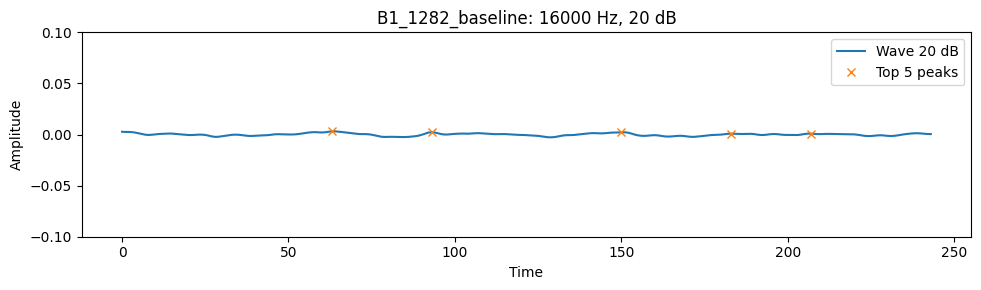

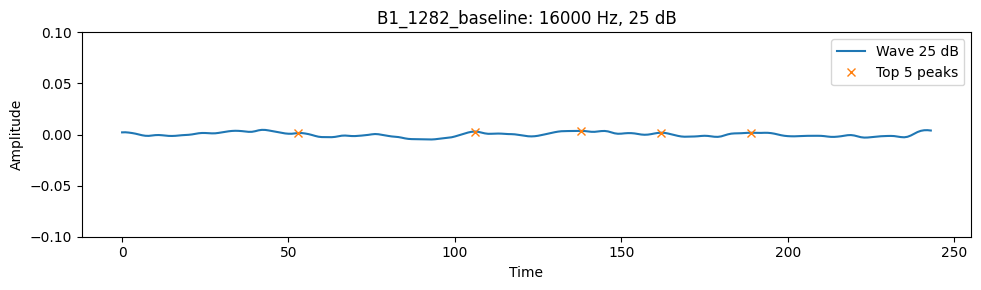

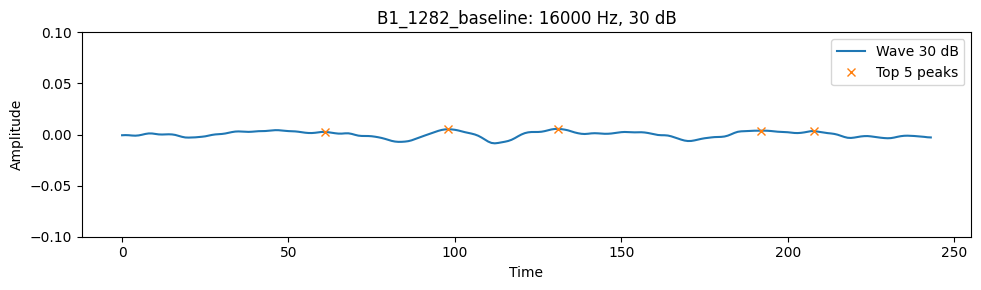

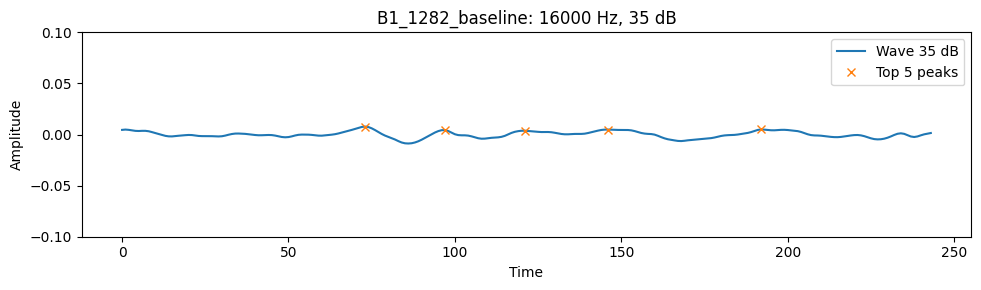

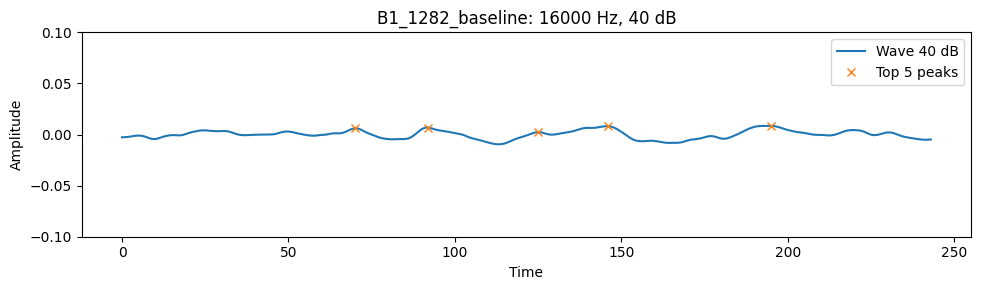

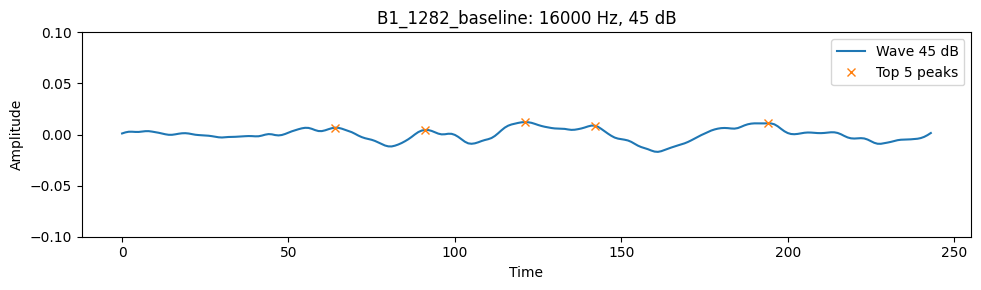

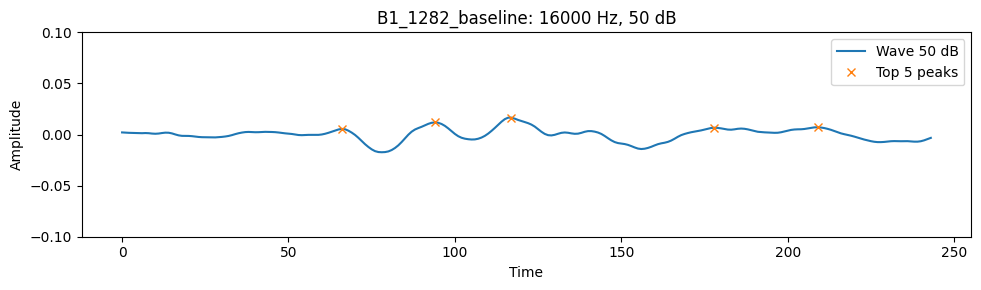

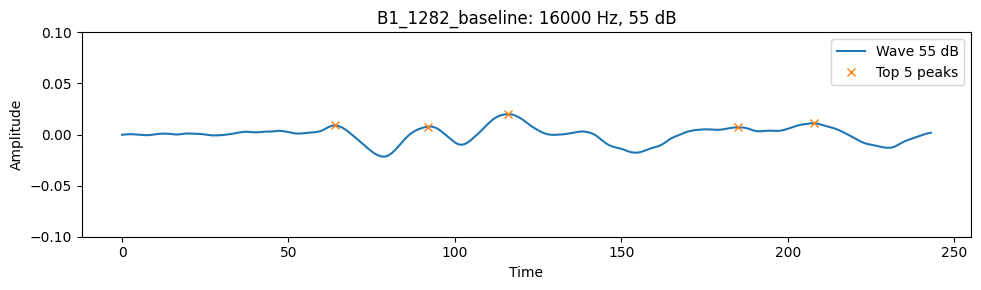

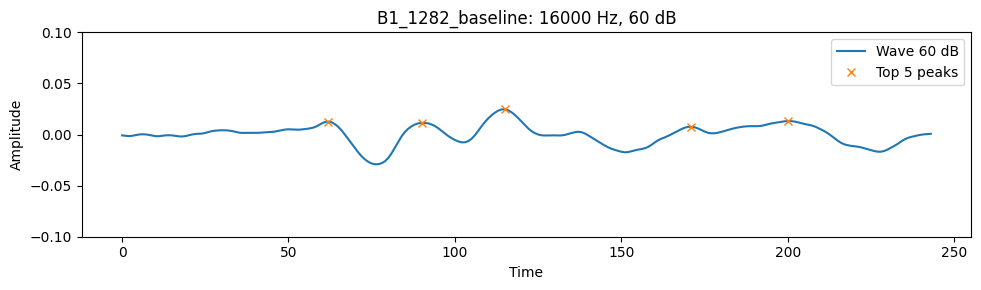

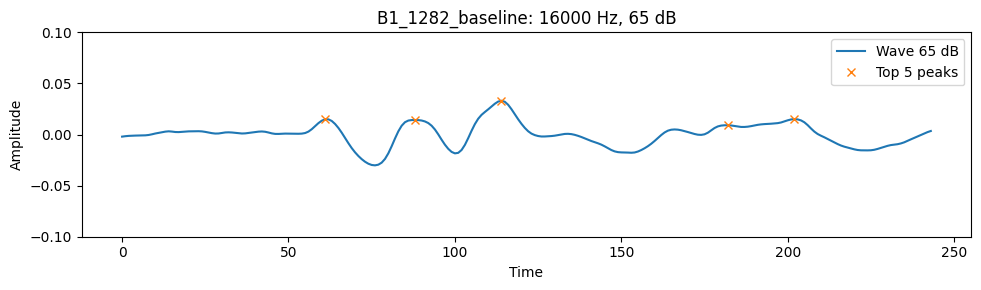

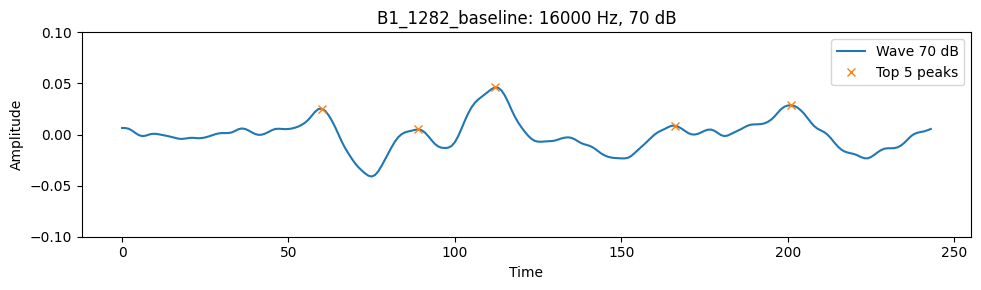

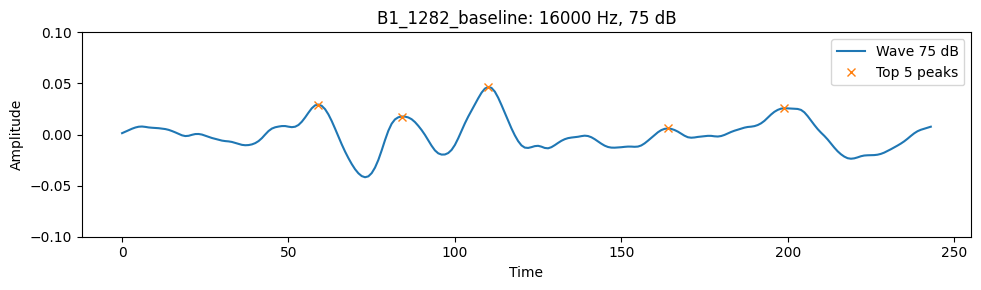

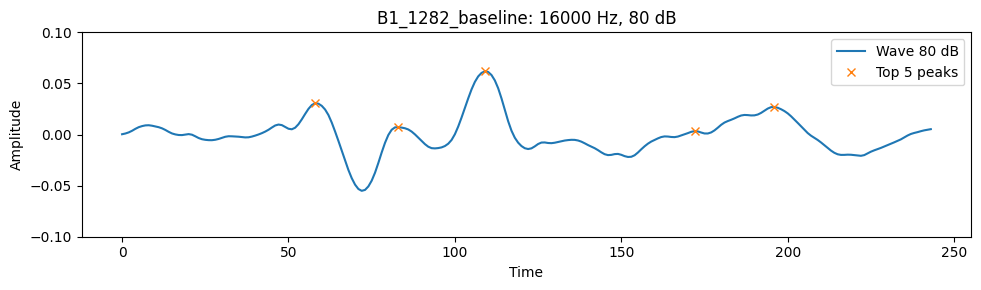

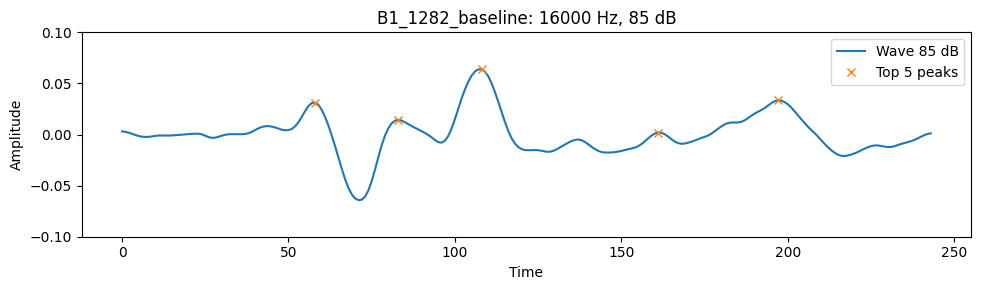

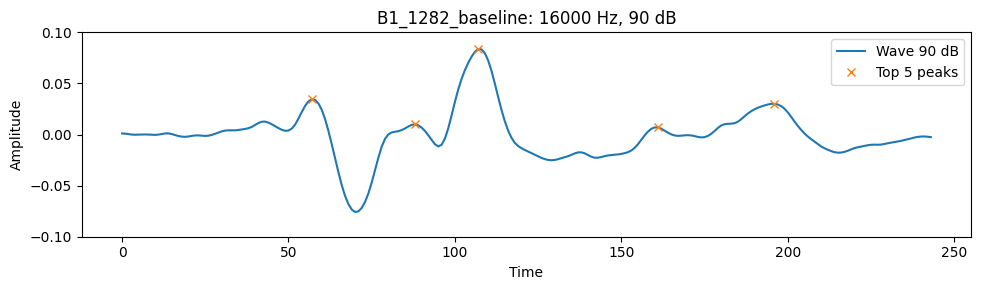

,Peaks,dB,Frequency
0,"[63, 0.003128, 93, 0.002283, 150, 0.002225, 18...",20,16000
1,"[53, 0.00151, 106, 0.002948, 138, 0.003558, 16...",25,16000
2,"[61, 0.002581, 98, 0.005151, 131, 0.005539, 19...",30,16000
3,"[73, 0.007784, 97, 0.004342, 121, 0.003757, 14...",35,16000
4,"[70, 0.006221, 92, 0.006866, 125, 0.002383, 14...",40,16000
5,"[64, 0.006713, 91, 0.004471, 121, 0.012171, 14...",45,16000
6,"[66, 0.005533, 94, 0.011853, 117, 0.01652, 178...",50,16000
7,"[64, 0.008857, 92, 0.007774, 116, 0.019961, 18...",55,16000
8,"[62, 0.012704, 90, 0.011371, 115, 0.024695, 17...",60,16000
9,"[61, 0.014885, 88, 0.014229, 114, 0.033075, 18...",65,16000


In [ ]:
peaks_list = []
db_values = []
freq_values = []

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            wave = final.tolist()[:-1]
            wave_after_30 = wave[50:-30]  # start from the 30th point and end before the last 30 points
            peaks, _ = find_peaks(wave_after_30, distance=15)
            peaks = [peak + 50 for peak in peaks]  # adjust the indices
            highest_peaks_indices = sorted(peaks, key=lambda x: wave[x], reverse=True)[:5]
            highest_peaks_indices.sort()
            peak_coordinates = []
            for peak in highest_peaks_indices:
                peak_coordinates.extend([peak, wave[peak]])
            peaks_list.append(peak_coordinates)
            db_values.append(dbkhz_value)
            freq_values.append(khz_value)
            fig, axs = plt.subplots(figsize=(10, 3))
            axs.plot(wave, label=f'Wave {dbkhz_value} dB')
            axs.plot(highest_peaks_indices, [wave[j] for j in highest_peaks_indices], "x", label='Top 5 peaks')
            axs.set_title(f'{filename}: {frequency} Hz, {dbkhz_value} dB')
            axs.set_xlabel('Time')
            axs.set_ylabel('Amplitude')
            axs.set_ylim(-.1,.1)
            axs.legend()
            plt.tight_layout()
            plt.show()

df_peaks = pd.DataFrame({
    'Peaks': peaks_list,
    'dB': db_values,
    'Frequency': freq_values
})

df_peaks


# K-Means on Peaks

# We need to scale x and y because they are on different scales

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_values = df_peaks['Peaks'].apply(lambda x: x[::2])
y_values = df_peaks['Peaks'].apply(lambda x: x[1::2])

max_len = max(df_peaks['Peaks'].apply(len))

x_values_padded = np.array([xi+[np.nan]*(max_len//2-len(xi)) for xi in x_values])
y_values_padded = np.array([yi+[np.nan]*(max_len//2-len(yi)) for yi in y_values])

reshaped_x = x_values_padded.reshape(-1, 1)
reshaped_y = y_values_padded.reshape(-1, 1)

scaled_x = scaler_x.fit_transform(reshaped_x)
scaled_y = scaler_y.fit_transform(reshaped_y)

scaled_x_reshaped = scaled_x.reshape(-1, max_len//2)
scaled_y_reshaped = scaled_y.reshape(-1, max_len//2)

scaled_peaks = [list(sum(zip(x, y), ())) for x, y in zip(scaled_x_reshaped, scaled_y_reshaped)]

df_scaled = pd.DataFrame({'Peaks': scaled_peaks})

df_peaks['Peaks_Scaled'] = df_scaled['Peaks']


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)

data = df_peaks['Peaks_Scaled'].apply(lambda x: [i if str(i) != 'nan' else 0 for i in x]).tolist()
kmeans.fit(data)
clusters = kmeans.labels_
df_peaks['Cluster'] = clusters
df_peaks

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Peaks,dB,Frequency,Peaks_Scaled,Cluster
0,"[63, 0.003128, 93, 0.002283, 150, 0.002225, 18...",20,16000,"[-1.2781205744831037, -0.7172203236519167, -0....",2
1,"[53, 0.00151, 106, 0.002948, 138, 0.003558, 16...",25,16000,"[-1.4749563919086328, -0.8202638525815911, -0....",2
2,"[61, 0.002581, 98, 0.005151, 131, 0.005539, 19...",30,16000,"[-1.3174877379682095, -0.7520564239761021, -0....",2
3,"[73, 0.007784, 97, 0.004342, 121, 0.003757, 14...",35,16000,"[-1.0812847570575743, -0.42069951357987506, -0...",2
4,"[70, 0.006221, 92, 0.006866, 125, 0.002383, 14...",40,16000,"[-1.140335502285233, -0.5202403267548324, -0.7...",2
5,"[64, 0.006713, 91, 0.004471, 121, 0.012171, 14...",45,16000,"[-1.2584369927405505, -0.48890694218536407, -0...",2
6,"[66, 0.005533, 94, 0.011853, 117, 0.01652, 178...",50,16000,"[-1.2190698292554447, -0.5640561165592922, -0....",0
7,"[64, 0.008857, 92, 0.007774, 116, 0.019961, 18...",55,16000,"[-1.2584369927405505, -0.3523647134923964, -0....",0
8,"[62, 0.012704, 90, 0.011371, 115, 0.024695, 17...",60,16000,"[-1.2978041562256566, -0.10736566788519188, -0...",0
9,"[61, 0.014885, 88, 0.014229, 114, 0.033075, 18...",65,16000,"[-1.3174877379682095, 0.03153293322458541, -0....",0


# Estimate Threshold